In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import scipy.stats as st
import json
import pickle

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/Colab\ Notebooks/BluebookForBulldozers/bfb_app/train_valid_cleaned_app.csv .
!cp /content/gdrive/MyDrive/Colab\ Notebooks/BluebookForBulldozers/bfb_app/bfb_categorizer_app.json .

In [ ]:
with open("bfb_categorizer_app.json", "r") as fin:
  data = fin.read()

bfb_categorizer = json.loads(data)

The metric for the <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation"> bluebook for bulldozers</a> competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices. So, let's set up some functions to calculated this metric easily on the training and validation sets. I've also made a function to easily create a random forest model with the same settings so it's easy to fit a new model to the training data as we pair down the number of features.

In [ ]:
def rmsle(y_targ, y_pred):
  return np.sqrt(mean_squared_log_error(y_targ, y_pred))

def show_scores(model, train_x, valid_x):
  train_preds = model.predict(train_x)
  valid_preds = model.predict(valid_x)
  scores = {"train_rmsle": rmsle(train_y, train_preds),
            "valid_rmsle": rmsle(valid_y, valid_preds)}
  return scores

def get_rf_model():
  return RandomForestRegressor(n_estimators=40, max_samples=0.5,
                               max_features=0.5, min_samples_leaf=5,
                               oob_score=True)

Let's open up the cleaned dataset, we need to reset the index, but everything else is already in order. To make training faster, a sample of the dataset can be used until we get an idea of what settings are working well for are data. We will want to make sure to use the full dataset for the final model.

In [ ]:
df_new = pd.read_csv("train_valid_cleaned_app.csv")
df_new = df_new.set_index("Unnamed: 0")
print(df_new.shape)
# df_new.head()

(412698, 56)


In [ ]:
# select which version of the dataframe to use for training and testing
use_sample = False

if use_sample is True:
  print("using sampled dataset")
  # sampled dataframe
  df = df_new.sample(frac=0.25, random_state=42)
else:
  print("using full dataset")
  # full dataframe
  df = df_new
print(df.shape)

using full dataset
(412698, 56)


Splitting the data for training and validation is important. Because the goal is to predict future prices of the equipment the split should be based on a date instead of a random split. This will give us some idea of how well the model does with slightly out-of-domain data.

In [ ]:
cond = (df["year"] < 2011) | (df["month"] < 10)
np.where(~cond)[0]

array([393137, 393138, 393139, ..., 401122, 401123, 401124])

In [ ]:
# split the data into train and valid based on the sale year
# validation should be the latest data so we can try to predict the trend in
# sale price over time
cond = (df["year"] < 2011) | (df["month"] < 10)
valid_set = df.iloc[list(np.where(~cond)[0])]
train_set = df.iloc[list(np.where(cond)[0])]

train_x, train_y = train_set.drop("SalePrice", axis=1), train_set["SalePrice"]
valid_x, valid_y = valid_set.drop("SalePrice", axis=1), valid_set["SalePrice"]

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

(404710, 55) (404710,)
(7988, 55) (7988,)


An initial training and evaluation of the model gives us a baseline to compare too as we start removing features. The goal end goal of this notebook is to have a model that only needs 5-10 features but still performs as close to the full model as possible. We want so few features to makde it easy to create an app for users to predict prices themselves.

In [ ]:
# initial test of the random forest regressor model on the data
model = get_rf_model()
model.fit(train_x, train_y)
show_scores(model, train_x, valid_x)

{'train_rmsle': 0.18276446989561487, 'valid_rmsle': 0.23793606449377325}

### Determine Confidence of Model Predictions

We'll start with getting an idea of the confidence in model predictions by looking at the standard deviation of of the decision trees within the random forest for each row in the validation set.

In [ ]:
# calculate the standard deviation in model predictions to gain and
# understanding of prediction confidence
valid_preds = np.array([t.predict(valid_x) for t in model.estimators_])
valid_preds_stddev = valid_preds.std(axis=0)

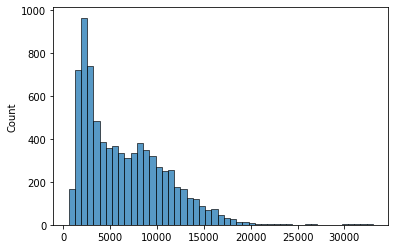

In [ ]:
valid_preds_stddev = valid_preds.std(axis=0)
sns.histplot(valid_preds_stddev)

In [ ]:
# get the ten least confident predictions
# sort and return last ten
least_conf_idxs = valid_preds_stddev.argsort()[-10:]
print(least_conf_idxs)
valid_preds_stddev[least_conf_idxs]

[2774 3619 3615 2806 2804 3616 2414 2419 2410 2412]


array([30282.74659815, 30934.31893089, 30934.31893089, 31413.13874992,
       31423.93444511, 31557.86885263, 31904.12624882, 31990.92598879,
       32607.16572565, 33049.78065264])

In [ ]:
valid_x.iloc[list(least_conf_idxs)]

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,year,month,day,day_of_year
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23413,1220718,1012172,16364,121,3.0,2009,3943.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,15,319
23524,1221147,1034292,16364,121,3.0,2009,3333.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,23,327
23521,1221144,1030258,16364,121,3.0,2009,2670.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,23,327
23415,1220720,1067889,16364,121,3.0,2009,3642.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,15,319
23416,1220721,1013161,16364,121,3.0,2009,3021.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,15,319
23522,1221145,1042159,16364,121,3.0,2009,2848.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,23,327
23227,1220107,1004449,16364,121,3.0,2009,3645.0,0,2948,949,177,123,12,6,32,3,1,1,0,0,0,1,1,2,4,0,1,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,3,307
23223,1220103,1030917,16364,121,3.0,2009,2424.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,3,307
23225,1220105,1050929,16364,121,3.0,2009,2313.0,0,2948,949,177,123,12,6,32,3,1,1,2,0,0,1,1,2,4,0,0,2,2,0,4,1,1,0,0,3,2,0,0,1,2,18,28,2,1,3,0,4,5,4,5,2011,11,3,307


### Determine Feature Importance and Remove Low-Importance Features

Next is determining what features are the most important to the model. This is the key step to feature reduction, and luckily sci-ki learn makes it easy by calculating feature importance for us. We'll create a dataframe with the feature names and their importance and sort from high to low. Then we'll pick a threshold and drop any feature that doesn't meet the requirement.

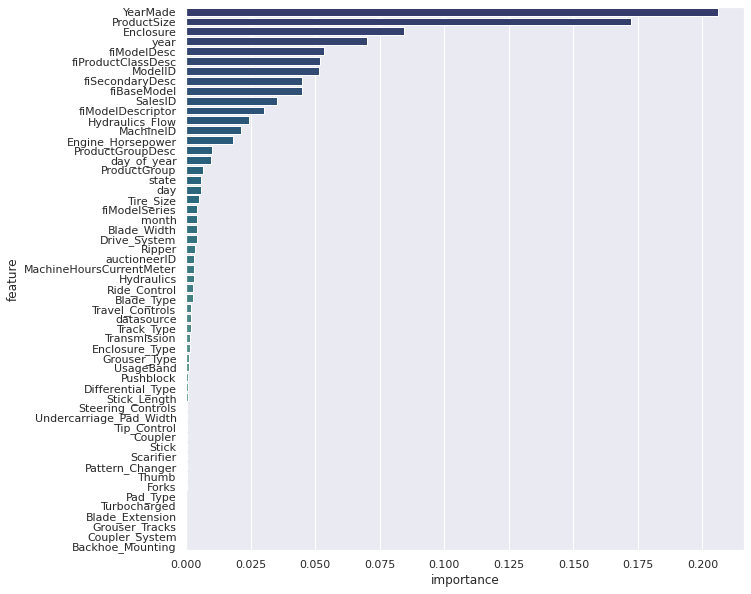

In [ ]:
# create dataframe of the feature importance for each columns, sort, and plot
feature_importance = pd.DataFrame({"feature": train_x.columns,
                                  "importance": model.feature_importances_})\
                                  .sort_values(by="importance", ascending=False)
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance, x="importance", y="feature", orient='h',
            palette="crest_r")
plt.show()

In [ ]:
# get only features with importance above a threshold
important_features = feature_importance.query("importance > 0.025")["feature"]
important_features

5               YearMade
13           ProductSize
19             Enclosure
51                  year
8            fiModelDesc
14    fiProductClassDesc
2                ModelID
10       fiSecondaryDesc
9            fiBaseModel
0                SalesID
12     fiModelDescriptor
Name: feature, dtype: object

In [ ]:
# update the training and validation sets to only use the importance features
train_x_imp = train_x[important_features]
valid_x_imp = valid_x[important_features]

Let's create and train a new model on the reduced features dataset. It looks pretty good, there is only a minimal impact on the validation data and seems like we are overfitting less on the training data.

In [ ]:
# create a new model to train on the important features only and re-evaluate
model_imp = RandomForestRegressor(n_estimators=40, max_samples=0.5,
                                  max_features=0.5, min_samples_leaf=5,
                                  oob_score=True)
model_imp.fit(train_x_imp, train_y)
show_scores(model_imp, train_x=train_x_imp, valid_x=valid_x_imp)

{'train_rmsle': 0.20119503436446912, 'valid_rmsle': 0.23958619613853305}

### Determining and Removing Feature Redundancy

Here we are going to look at the correlation between the remaining features and link them in a hierarchical structure. The closer the connection to the right of the plot between two or more features the more their values are correlated. Removing correlated features can help simplify the model (why use two features if one will work), but it also helps make the ensembling of decision trees more robust. It's less likely that different trees could be correlated using different randomly selected features, if different trees are more correlated then the errors they have will tend in the same direction and make ensembling less able to reduce the overall error.

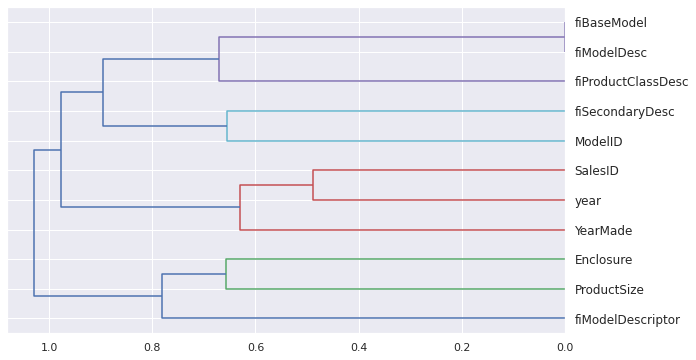

In [ ]:
# https://github.com/fastai/fastbook/blob/master/utils.py
corr = np.round(st.spearmanr(train_x_imp).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method='average')
plt.figure(figsize=(10, 6))
dn = hc.dendrogram(z, labels=train_x_imp.columns, orientation='left')
plt.show()

To see which features we can remove, we are using the out-of-box socre. So, when a tree is trained in a random forest, it's only trained on a random selection of the rows. Out-of-box error is the error calculated for a decision tree using the data it was not randomly assigned when training. The oob_score metric is a normalized version of the error, so a higher value means better performance.

We'll start be creating a function to fit and score a model and benchmark that on the current dataset. Then we'll loop one-by-one through the redundant fields identified above (fiBaseModel and fiModelDesc) as well as some other fields that I think would not be useful to have in a user interface. Users won't have a SalesID if they are trying to assess the price of equipment. ModelID and fiModelDescriptor are something I didn't think would be as useful for a user as the other model features present. Finally, year is the year sold, which I want to keep at 2012 to make predictions closer to the training data. 

In [ ]:
# create function to train model and get OOB score
def get_oob_score(train_x, train_y):
  m = get_rf_model()
  m.fit(train_x, train_y)
  return m.oob_score_

# baseline with all redundant features
get_oob_score(train_x_imp, train_y)

0.8925649986107943

In [ ]:
# redundant and/or unneccessary features we want to test to see if we can drop them
redundant_features = ["ModelID", "SalesID", "year", "fiBaseModel",
                      "fiModelDesc", "fiModelDescriptor"]

# loop through each feature, dropping it from the training set and getting the
# resulting OOB score, a higher score for that feature means the model performs
# better without it
results = {}
for feature in redundant_features:
  results[feature] = get_oob_score(train_x_imp.drop(feature, axis='columns'),
                                   train_y)
results

{'ModelID': 0.8931342898708906,
 'SalesID': 0.8932517140179872,
 'fiBaseModel': 0.8925147880654365,
 'fiModelDesc': 0.8926165802806717,
 'fiModelDescriptor': 0.892407555773888,
 'year': 0.8077924961610502}

There are a few things to note. Removing any of these features does not have a large impact on performance, except for year so that one will definetly stay. I also decided to keep fiModelDescriptor because performance dropped a bit. Between fiBaseModel and fiModelDesc, there is a slightly greater improvement removing fiModelDesc so that is the one we'll take out. Now we'll remove these features and fit and train a new model on the remaining 8 features.

In [ ]:
# redundant features to drop from the training and validation sets
to_drop = ["SalesID", "ModelID", "fiModelDesc"]
train_x_final = train_x_imp.drop(to_drop, axis='columns')
valid_x_final = valid_x_imp.drop(to_drop, axis='columns')
len(train_x_final.columns)

8

In [ ]:
train_x_final.columns

Index(['YearMade', 'ProductSize', 'Enclosure', 'year', 'fiProductClassDesc',
       'fiSecondaryDesc', 'fiBaseModel', 'fiModelDescriptor'],
      dtype='object')

In [ ]:
# train new model without the redundant features and evaluate
model_final = get_rf_model()
model_final.fit(train_x_final, train_y)
show_scores(model_final, train_x=train_x_final, valid_x=valid_x_final)

{'train_rmsle': 0.21349768646174544, 'valid_rmsle': 0.23978420950479296}

The validation RMSLE on the full dataset model was 0.2379, and now we are at 0.2398. Not too bad for removing about 85% percent of the features (and therefore 85% of the data used to make a prediction). We end up with a model that is easier to use and easier to interpret now.

### Partial Dependence

In this last section, I am taking a closer look at the most important features and gauging their impact on the predictions. First by looking again at the count of each value in the features, just a check to make sure there's nothing too funcky going on. Second by creating partial dependence plots, which show how changing a feature impacts the prediction.

The way a partial dependence plot works is by changing the feature in questions to the same value for the entire dataset (here we are using the validation data) and averaging the prediction for all the rows. It loops through all the values for a given feature, averages all the predictions, and then plots the results. To be clear, these predictions are based on some hypothetical inputs, because, for example, with YearMade it will change all the rows in the validation set to 1950 and predict all the prices and average that, then it changes them to 1951 and so on and so forth. It will create some inputs that cannot exist, but it shows us the dependence of the output to a specific feature without incurring impacts from other, possibly hidden, correlations. Like new upgrades only available in later years.

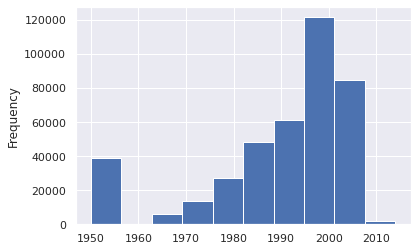

In [ ]:
train_x_final["YearMade"].plot.hist()

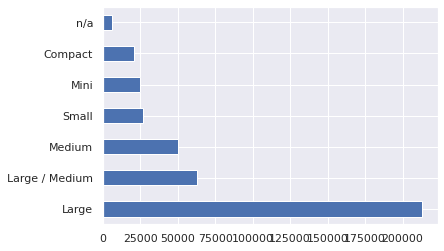

In [ ]:
train_x_final["ProductSize"].value_counts().plot.barh()
labels = bfb_categorizer["ProductSize"]
plt.yticks(range(len(labels)), labels)
plt.show()

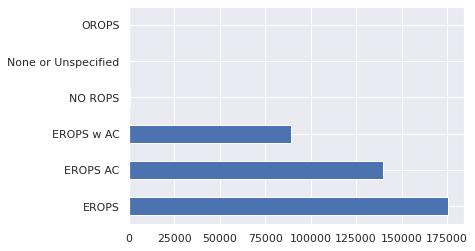

In [ ]:
train_x_final["Enclosure"].value_counts().plot.barh()
labels = bfb_categorizer["Enclosure"]
plt.yticks(range(len(labels)), labels)
plt.show()

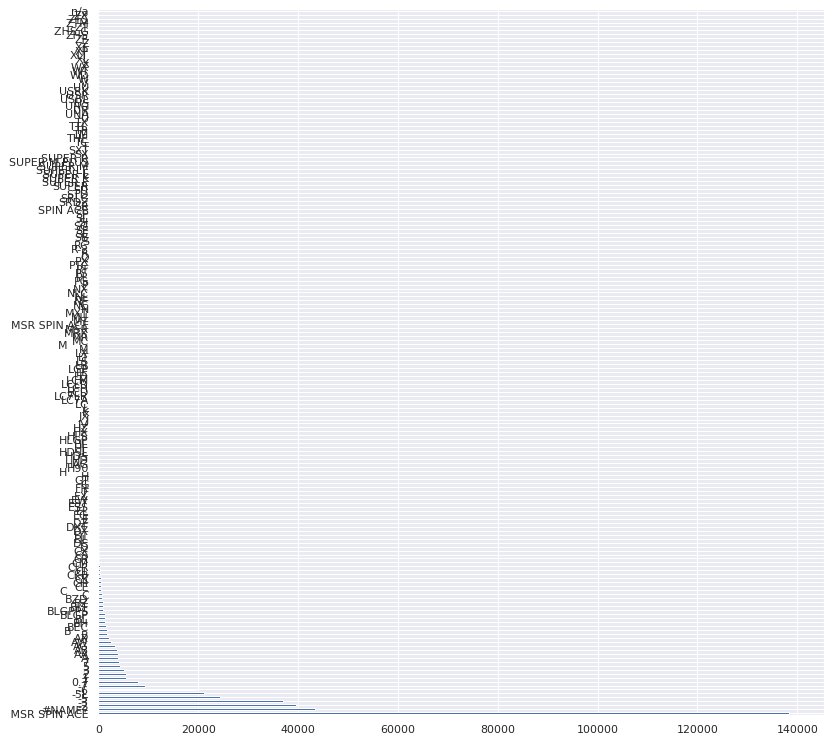

In [ ]:
plt.figure(figsize=(13, 13))
train_x_final["fiSecondaryDesc"].value_counts().plot.barh()
labels = bfb_categorizer["fiSecondaryDesc"]
plt.yticks(range(len(labels)), labels)
plt.show()

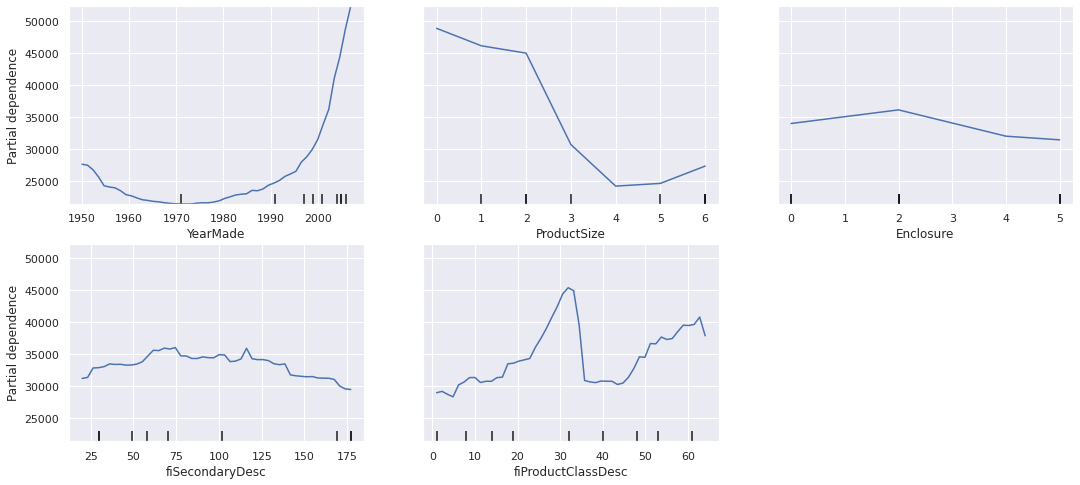

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
plot_partial_dependence(model_final, valid_x_final, ["YearMade", "ProductSize",
                                                     "Enclosure",
                                                     "fiSecondaryDesc",
                                                     "fiProductClassDesc"], ax=ax,
                        grid_resolution=50)

In [ ]:
with open("bfb_app_rf_model.pkl", 'wb') as fout:
  pickle.dump(model_final, fout)

In [ ]:
!cp bfb_app_rf_model.pkl /content/gdrive/MyDrive/Colab\ Notebooks/BluebookForBulldozers/bfb_app/.